# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [99]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd

from smstools.models import utilFunctions as UF
from smstools.models import stft as STFT
from smstools.models import hpsModel as HPS
import IPython.display as ipd

Text(0.5, 1.0, 'magnitude spectrogram')

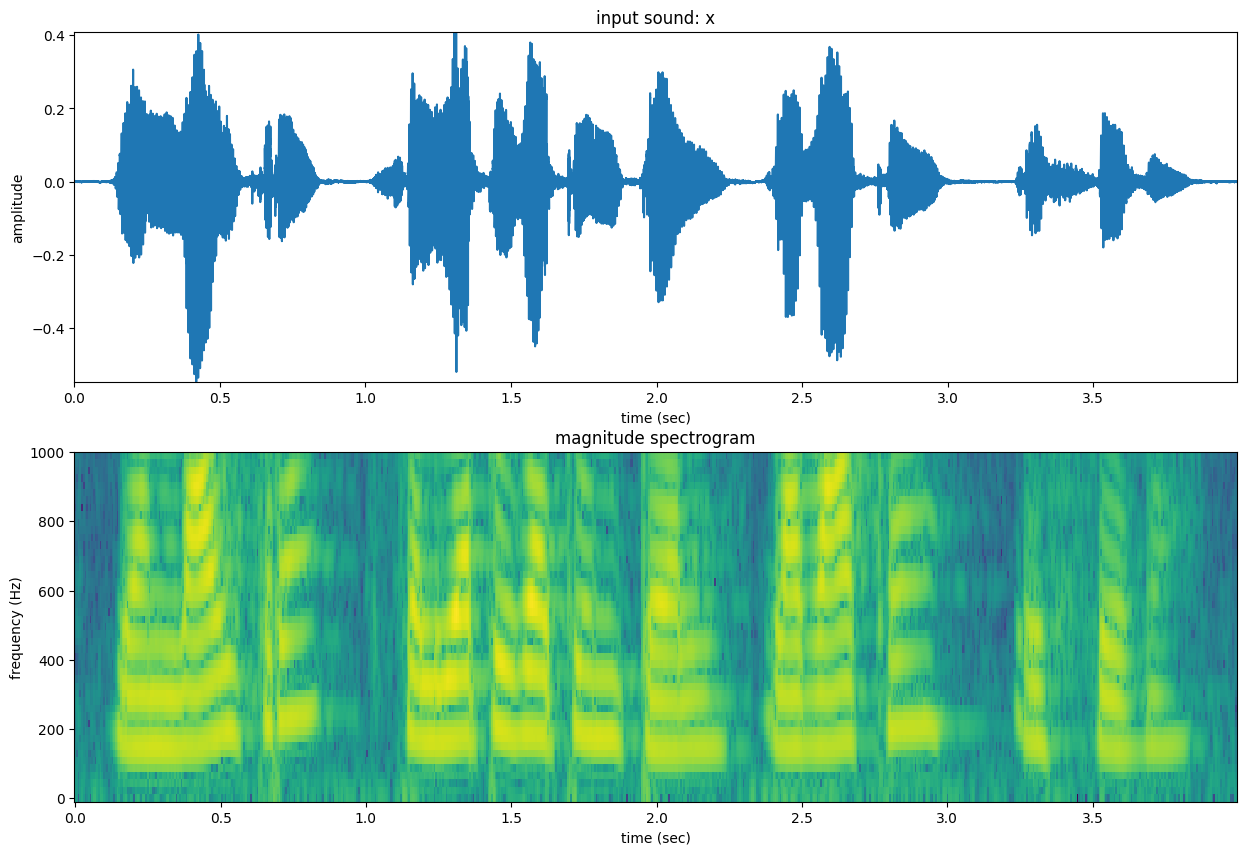

In [100]:
# E7 - 1.1: 
# Set STFT analysis parameters and visualize spectrogram of speech-female.wav sound





input_file = '../sounds/speech-female.wav'

### set parameters
'''
window = 'XX'
M = XX
N = XX
H = XX
'''

window = 'hann'
M = 1024
N = 2048
H = 256

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')



In [101]:
# E7 - 1.2: 
# Perform Harmonic plus Stochastic analysis and synthesis of speech-female.wav sound



input_file = '../sounds/speech-female.wav'

### fill the parameters
'''
window ='XXX'
M = XXX
N = XXX
t = XXX
minSineDur = XXX
nH = XXX 
minf0 = XXX
maxf0 = XXX
f0et = XXX
harmDevSlope = XXX
stocf = XXX
'''


window = 'blackman'
M = 2048
N = 4096
t = -80
minSineDur = 0.05
nH = 30
minf0 = 150
maxf0 = 350
f0et = 5
harmDevSlope = 0.01
stocf = 0.3




# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))


**ANALYSIS FOR 1.1 AND 1.2**

**========== 1.1 ==========**

* The sound is a short phrase narrated by a woman (around 4 seconds at 44.1KHz) and has a clear alternation between vowels and consonants.

* The waveform shows moderate energy (RMS≈0.069, peak≈0.55) and a relatively high zero crossing rate. It's consistent though, with fricatives and unvoiced segments with some periodic voiced portions.

* In the spectrogram the voiced regions show an almost clear harmonic structure, with a fundamental that's common in a femal vocal range (usually between 200 and 300Hz) and multiple harmonics visible.

* Consonants appear as a broadband, with less energy

* The global spectral centroid is around 1726 Hz. It shows that most energy is concentrated in the low-mid frequencies. There's also a non negligble high frequency contribution.

* Overall, it looks like a monophonic, harmonic signal in the vowels with a strong stochastic component in consonants. 
These features mentioned make the audio well suited for harmonic and stochastic representation (HPS).

* The waveform shows moderate energy (RMS around 0.0686, peak around 0.5461) and a relatively high zero-crossing rate (aprox 1968 crossings/s).  

* The global spectral centroid is around 1726.39 Hz.  

**========== 1.2 ==========**

window = 'blackman'
M = 2048
N = 4096
t = -80
minSineDur = 0.05
nH = 30
minf0 = 150
maxf0 = 350
f0et = 5
harmDevSlope = 0.01
stocf = 0.3

Analysis parameters + justification:
* Window type: Blackman window because it minimizes spectral leaks and usually produces cleaner and isolated harmonic peaks.

* Window size: M=2048 because a 2048 smaple provides enough frequency resolution to separate harmonics of a female voice with a f0 estimated between 180 and 300 Hz

* FFT size: N=4096 as setting it up to the next power of two above M shows to achieve a good spectral interolation without overhead of resources.

* Minimum f0: set 150Hz, slightly below 200 Hz to avoice detecting unrealistically low fundamentals 

* Maximum f0: 350Hz slightly aboe as it covers the highest expected female voice pitch without introducing false frequencies

* Error threshold in f0 to 5: a low error threshold usually ensures that only the stable harmonic frames are kept

* Number of harmonics to 30: to allow up to 30 harmonics /partials so I can capture all perceptually relevant partials up to a certain amount of KHz

* Threshold -80dB: to remove small peaks while keeping relevant harmonic peaks.

* Minimum sine duration to 0.05s: tracks that are shorter than 0.1s are discarded to avoid noisy harmonic detections.

* Harmonic deviation slope to 0.01: to allow higher harmonics to deviate slightly more from the ideal harmonicity in order to improve the tracking of real speech inharmonicity
Stochastic stocf to 0.2: to decimate the residual magnitude spectrum by a factor that provides a compact but accurate stochastic.

* stochastic factor stocf 0.3: produces a compact residual, enough for consonant noise without oversmoothing.  


**Question E7 - 1.3:**

### Explain the HPS analysis parameters used
____
* Harmonic structure: the analysis produced 1377 frames, with harmonic counts that range from 0 to 45 harmonics. There was an average of 10.37 harmonics per frame which reflects the alternation between harmonic vowels (many harmonics) and noisy consonants.

* Voiced vs unvoiced segmentation: about 2/3 of the frames contain harmonics, meaning one third of the signal is unvoiced noise, which confirms that the f0 limits avoid false detections

* Spectral detail: the presence of around 20 harmonics in vocied frames shows that the analysis is succesful in capturing the upper harmonics that are relevant for intelligibility and timbre   

* Stochastic model: the envolope has shape (1377,38) which means each frame is represented by 25 coefficients, which suggests a compact residual representation suitable for noisy sounds.    

* Overall perception: given the harmonic coverage and the compact stochastic, the output produces vowels almost clearly and models consonant noise. 

* Computational performance: the HPS analysis when executed in my laptop took 5.47s of wall time with 7MB peak memory, showing that although harmonic tracking is computational heavier than STFT, it it gives a better time-frequency representation.


**REFACTORED CODE FOR DEEPER and NUMERICAL ANALYSIS**


============================ PART 1.1 ============================
Signal characteristics:
Sample rate: 44100 hz
Duration: 3.994 s
RMS level: 0.068591
Peak amplitude: 0.546112
Zero-crossing rate: 1967.78 crossings
Spectral centroid (global): 1726.39 hz


============================ PART 1.2 ============================


HPS analysis characteristics:
Frames: 1377
Max harmonics per frame: 20
Min harmonics per frame: 0
Mean harmonics per frame: 8.81
Stochastic envelope shape: (1377, 38)
============================ RESOURCE USAGE  ============================
Test name | Wall time (s) | CPU time (s) | Peak memory (MB)
STFT_1_hann_M1024_N2048_H256 | 0.9844 | 0.9707 | 21.31
STFT_2_hann_M2048_N4096_H512 | 0.9122 | 0.9052 | 21.31
HPS_full_blackman_M2048_N4096 | 4.6699 | 4.6061 | 5.28


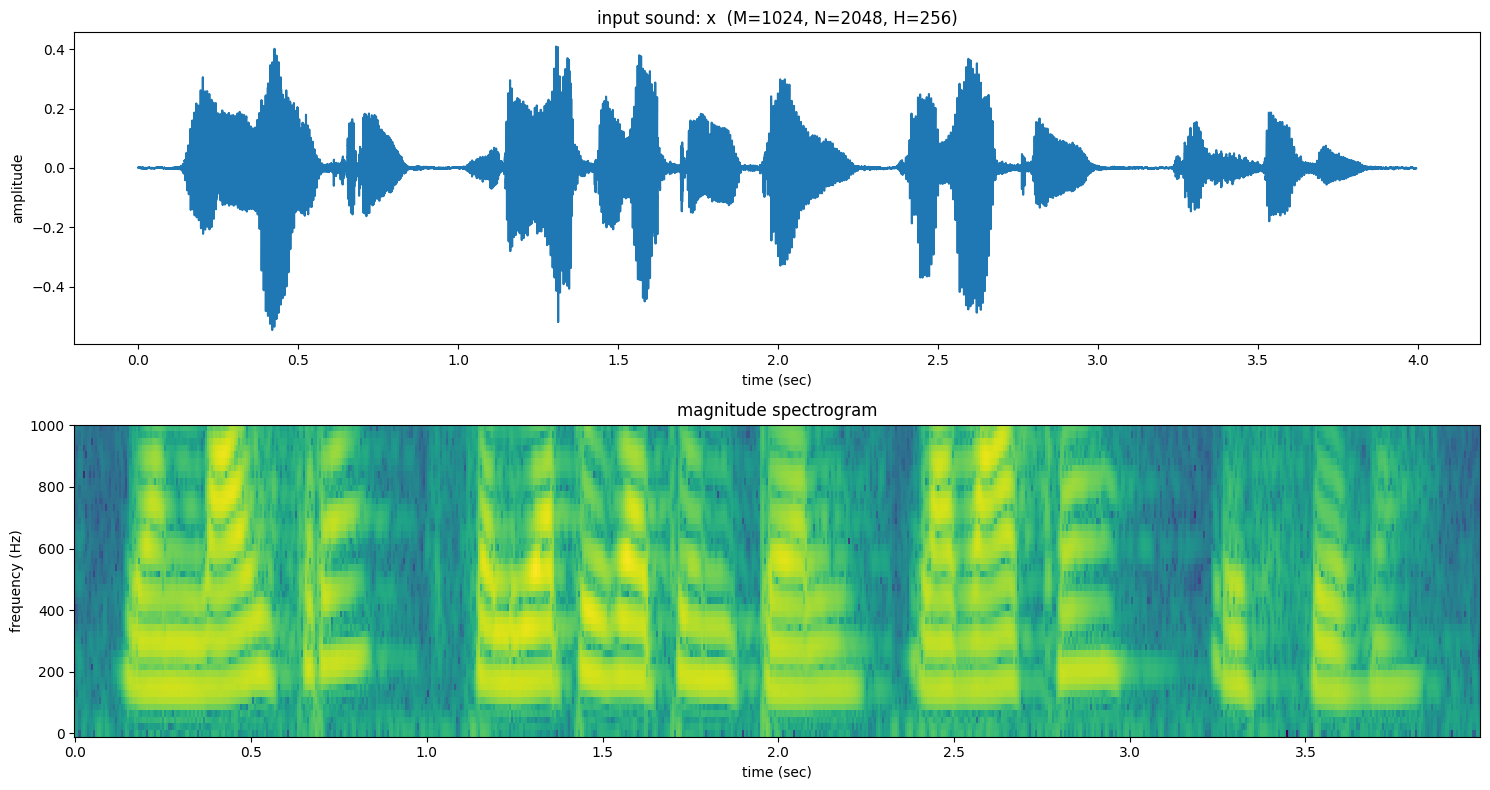

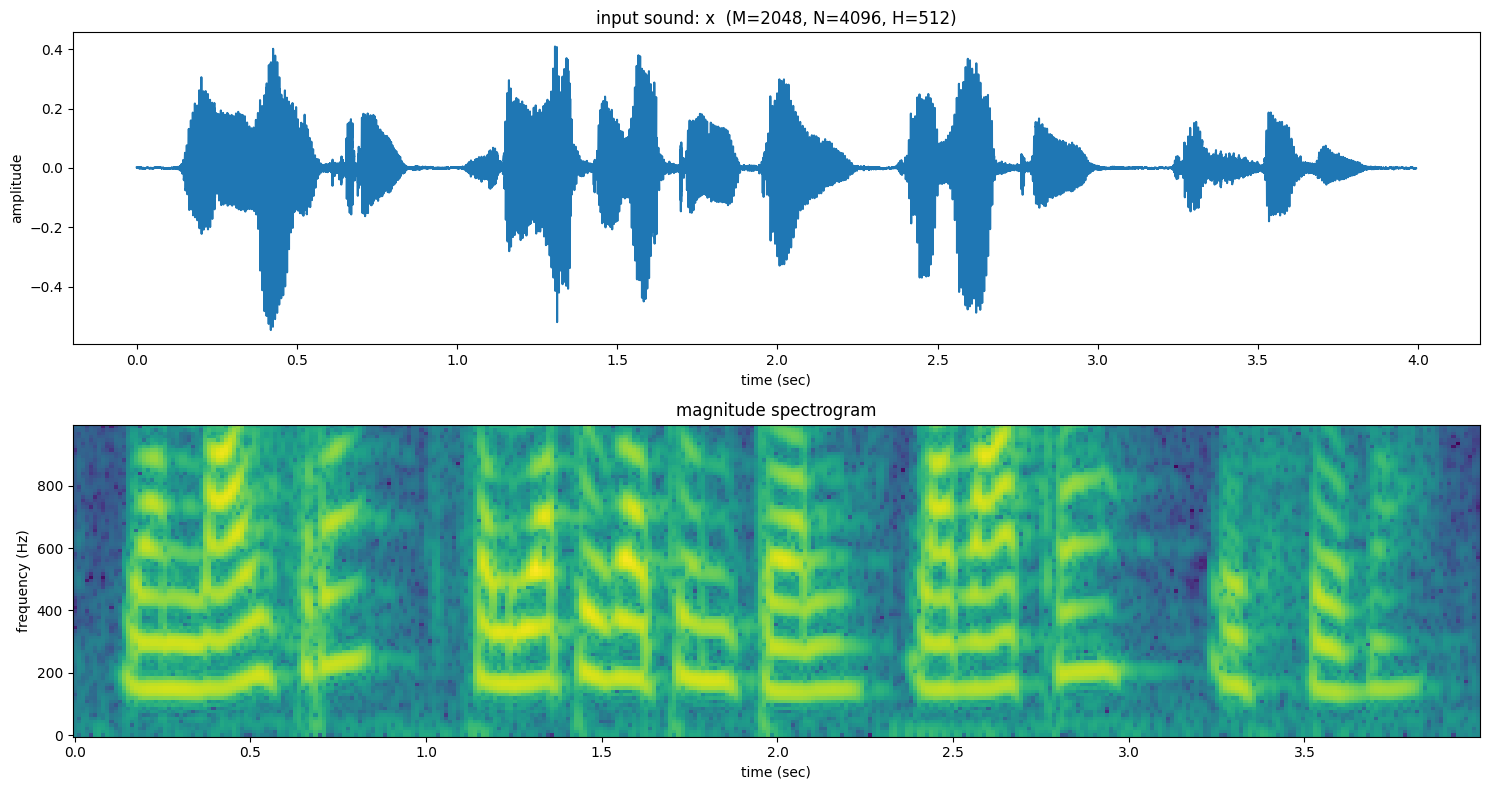

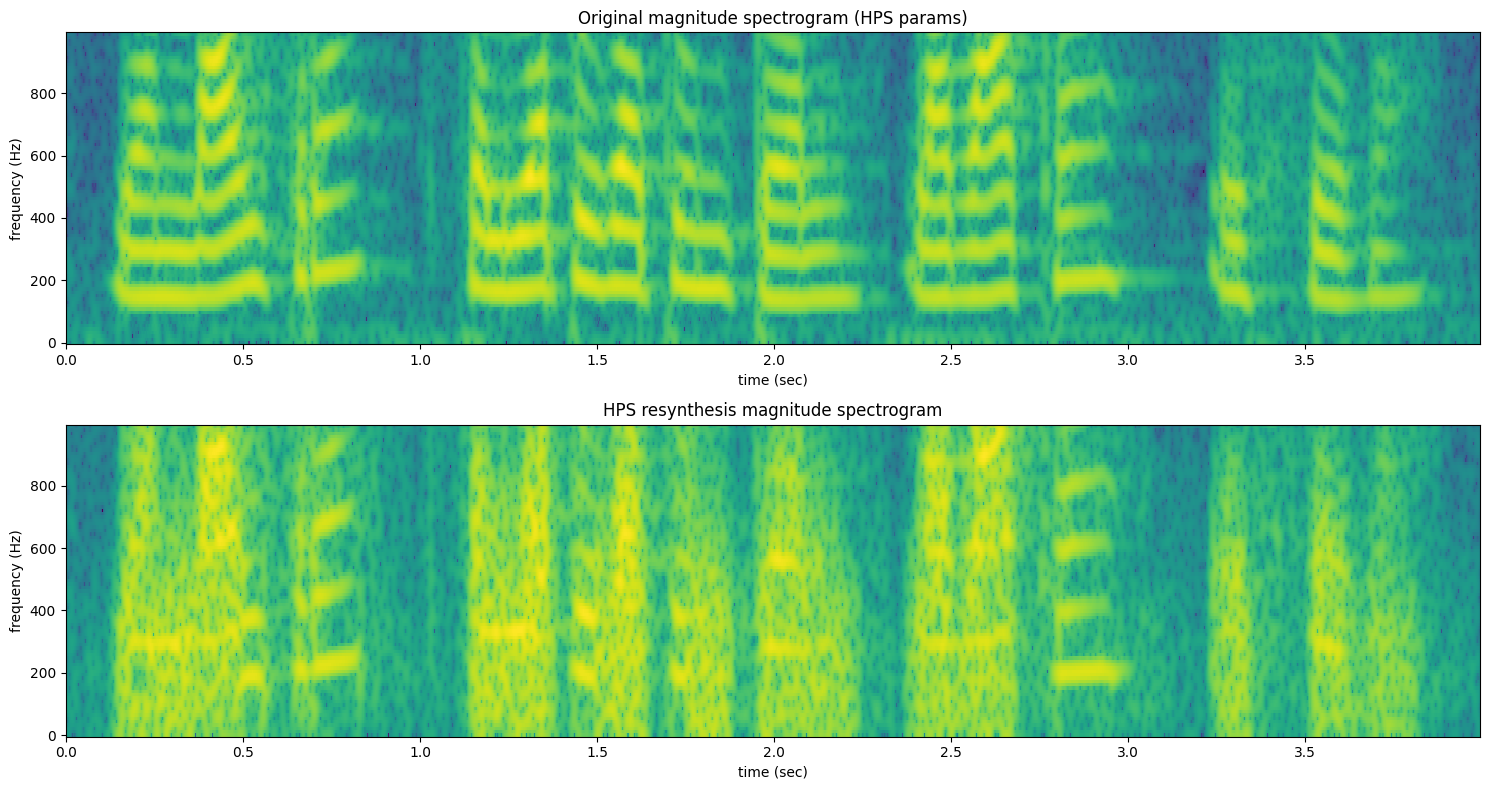

In [102]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd
from smstools.models import utilFunctions as UF
from smstools.models import stft as STFT
from smstools.models import hpsModel as HPS
import time
import tracemalloc

input_file = '../sounds/speech-female.wav'
fs, x = UF.wavread(input_file)

resource_results = []

def measure_and_run(name, func, *args, **kwargs):
    tracemalloc.start()
    t0_wall = time.perf_counter()
    t0_cpu = time.process_time()
    result = func(*args, **kwargs)
    cpu = time.process_time() - t0_cpu
    wall = time.perf_counter() - t0_wall
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    resource_results.append({"name": name, "wall": wall, "cpu": cpu, "mem_mb": peak / (1024.0 * 1024.0)})
    return result

print("============================ PART 1.1 ============================")

def stft_analysis(window, M, N, H):
    w = get_window(window, M, fftbins=True)
    mX, pX = STFT.stftAnal(x, w, N, H)
    maxplotfreq = 1000.0
    numFrames = int(mX[:, 0].size)
    frmTime = H * np.arange(numFrames) / float(fs)
    binFreq = fs * np.arange(int(N * maxplotfreq / fs) + 1) / N
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(x.size) / float(fs), x)
    plt.xlabel("time (sec)")
    plt.ylabel("amplitude")
    plt.title(f"input sound: x  (M={M}, N={N}, H={H})")
    plt.subplot(2, 1, 2)
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:, :int(N * maxplotfreq / fs) + 1]))
    plt.xlabel("time (sec)")
    plt.ylabel("frequency (Hz)")
    plt.title("magnitude spectrogram")
    plt.tight_layout()
    return mX

mX_1 = measure_and_run("STFT_1_hann_M1024_N2048_H256", stft_analysis, "hann", 1024, 2048, 256)
mX_2 = measure_and_run("STFT_2_hann_M2048_N4096_H512", stft_analysis, "hann", 2048, 4096, 512)

duration_sec = x.size / float(fs)
rms = np.sqrt(np.mean(x**2))
peak = np.max(np.abs(x))
zcr = np.sum(x[:-1] * x[1:] < 0) / duration_sec
N_fft = 2 ** int(np.ceil(np.log2(x.size)))
X_full = np.fft.rfft(x, n=N_fft)
mag_full = np.abs(X_full)
freqs_full = np.fft.rfftfreq(N_fft, d=1.0 / fs)
spectral_centroid = np.sum(freqs_full * mag_full) / np.sum(mag_full)

print("Signal characteristics:")
print(f"Sample rate: {fs} hz")
print(f"Duration: {duration_sec:.3f} s")
print(f"RMS level: {rms:.6f}")
print(f"Peak amplitude: {peak:.6f}")
print(f"Zero-crossing rate: {zcr:.2f} crossings")
print(f"Spectral centroid (global): {spectral_centroid:.2f} hz")

ipd.display(ipd.Audio(data=x, rate=fs))

print("============================ PART 1.2 ============================")

Ns = 512
H_hps = 128

hps_params = {
    "window": "blackman",
    "M": 2048,
    "N": 4096,
    "t": -80,
    "minSineDur": 0.1,
    "nH": 20,
    "minf0": 180,
    "maxf0": 350,
    "f0et": 5,
    "harmDevSlope": 0.01,
    "stocf": 0.3
}

def hps_run(params):
    w = get_window(params["window"], params["M"], fftbins=True)
    hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(
        x, fs, w, params["N"], H_hps,
        params["t"], params["nH"], params["minf0"], params["maxf0"],
        params["f0et"], params["harmDevSlope"], params["minSineDur"],
        Ns, params["stocf"]
    )
    y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H_hps, fs)
    return y, yh, yst, hfreq, hmag, hphase, stocEnv

y, yh, yst, hfreq, hmag, hphase, stocEnv = measure_and_run("HPS_full_blackman_M2048_N4096", hps_run, hps_params)

ipd.display(ipd.Audio(data=y, rate=fs))
ipd.display(ipd.Audio(data=yh, rate=fs))
ipd.display(ipd.Audio(data=yst, rate=fs))

active_harmonics_per_frame = np.sum(hfreq > 0, axis=1)
mean_harmonics = np.mean(active_harmonics_per_frame)
max_harmonics = np.max(active_harmonics_per_frame)
min_harmonics = np.min(active_harmonics_per_frame)

print("HPS analysis characteristics:")
print(f"Frames: {hfreq.shape[0]}")
print(f"Max harmonics per frame: {max_harmonics}")
print(f"Min harmonics per frame: {min_harmonics}")
print(f"Mean harmonics per frame: {mean_harmonics:.2f}")
print(f"Stochastic envelope shape: {stocEnv.shape}")

w_plot = get_window(hps_params["window"], hps_params["M"], fftbins=True)
mX_orig, pX_orig = STFT.stftAnal(x, w_plot, hps_params["N"], H_hps)
mX_y, pX_y = STFT.stftAnal(y, w_plot, hps_params["N"], H_hps)

maxplotfreq = 1000.0
numFrames_orig = int(mX_orig[:, 0].size)
frmTime_orig = H_hps * np.arange(numFrames_orig) / float(fs)
binFreq = fs * np.arange(int(hps_params["N"] * maxplotfreq / fs) + 1) / hps_params["N"]

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.pcolormesh(frmTime_orig, binFreq, np.transpose(mX_orig[:, :int(hps_params["N"] * maxplotfreq / fs) + 1]))
plt.xlabel("time (sec)")
plt.ylabel("frequency (Hz)")
plt.title("Original magnitude spectrogram (HPS params)")
plt.subplot(2, 1, 2)
plt.pcolormesh(frmTime_orig, binFreq, np.transpose(mX_y[:, :int(hps_params["N"] * maxplotfreq / fs) + 1]))
plt.xlabel("time (sec)")
plt.ylabel("frequency (Hz)")
plt.title("HPS resynthesis magnitude spectrogram")
plt.tight_layout()

print("============================ RESOURCE USAGE  ============================")
print("Test name | Wall time (s) | CPU time (s) | Peak memory (MB)")
for r in resource_results:
    print(f"{r['name']} | {r['wall']:.4f} | {r['cpu']:.4f} | {r['mem_mb']:.2f}")

In [103]:
import numpy as np

L = min(len(x), len(y))
x_al = x[:L]
y_al = y[:L]
e = x_al - y_al

rms_x = np.sqrt(np.mean(x_al**2))
rms_y = np.sqrt(np.mean(y_al**2))
rms_e = np.sqrt(np.mean(e**2))
snr = 20 * np.log10(rms_x / rms_e)

peak_x = np.max(np.abs(x_al))
peak_y = np.max(np.abs(y_al))

Lh = min(len(x), len(yh))
yh_al = yh[:Lh]
yst_al = yst[:Lh]

rms_yh = np.sqrt(np.mean(yh_al**2))
rms_yst = np.sqrt(np.mean(yst_al**2))

active_harmonics_per_frame = np.sum(hfreq > 0, axis=1)
mean_harmonics = np.mean(active_harmonics_per_frame)
max_harmonics = np.max(active_harmonics_per_frame)
min_harmonics = np.min(active_harmonics_per_frame)

nonzero_frames = np.sum(active_harmonics_per_frame > 0)
frac_nonzero_frames = nonzero_frames / active_harmonics_per_frame.size

print("===== HPS Numerical Analysis Part 1.2 =====")
print(f"Original RMS: {rms_x:.6f}")
print(f"Resynthesis RMS: {rms_y:.6f}")
print(f"Error RMS: {rms_e:.6f}")
print(f"SNR (x vs y): {snr:.2f} dB")
print(f"Original peak: {peak_x:.6f}")
print(f"Resynthesis peak: {peak_y:.6f}")
print(f"Harmonic component RMS (yh): {rms_yh:.6f}")
print(f"Stochastic component RMS (yst): {rms_yst:.6f}")
print(f"Frames: {hfreq.shape[0]}")
print(f"Max harmonics per frame: {max_harmonics}")
print(f"Min harmonics per frame: {min_harmonics}")
print(f"Mean harmonics per frame: {mean_harmonics:.2f}")
print(f"Fraction of frames with harmonics: {frac_nonzero_frames:.3f}")
print(f"Stochastic envelope shape: {stocEnv.shape}")

===== HPS Numerical Analysis Part 1.2 =====
Original RMS: 0.068591
Resynthesis RMS: 0.066484
Error RMS: 0.071463
SNR (x vs y): -0.36 dB
Original peak: 0.546112
Resynthesis peak: 0.674885
Harmonic component RMS (yh): 0.043961
Stochastic component RMS (yst): 0.049260
Frames: 1377
Max harmonics per frame: 20
Min harmonics per frame: 0
Mean harmonics per frame: 8.81
Fraction of frames with harmonics: 0.669
Stochastic envelope shape: (1377, 38)


## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [104]:
# E7 - 2.1: 
# Download a sound from freesound, read it with waveread, and describe it

#### your code here
'''
input_file = '/trumpet-vibrato.wav'
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

'''

"\ninput_file = '/trumpet-vibrato.wav'\n(fs, x) = UF.wavread(input_file)\nipd.display(ipd.Audio(data=x, rate=fs))\n\n"

**REFACTORED CODE**

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample_poly
import IPython.display as ipd
from smstools.models import utilFunctions as UF
import requests
import os
import math
import soundfile as sf

api_key = 'RyxVkKLbV8VUlkfb4QShilfmPTgevqv6BfEBEhTV'
sound_id = 374180

meta_url = f'https://freesound.org/apiv2/sounds/{sound_id}/?token={api_key}'
meta_response = requests.get(meta_url)
if not meta_response.ok:
    print("HTTP status:", meta_response.status_code)
    print(" response text:", meta_response.text)
    raise RuntimeError("Could not get metadata from Freesound. error de API KEY .")

meta = meta_response.json()
preview_url = meta["previews"]["preview-hq-ogg"]

os.makedirs('../sounds', exist_ok=True)
raw_path = '../sounds/trumpet_susvib_D5_preview.ogg'
audio_response = requests.get(preview_url)
if not audio_response.ok:
    print("Audio HTTP status:", audio_response.status_code)
    raise RuntimeError("Could not download preview audio from Freesound.")
with open(raw_path, 'wb') as f:
    f.write(audio_response.content)

x_raw, fs_raw = sf.read(raw_path)
if x_raw.ndim > 1:
    x_mono = np.mean(x_raw, axis=1)
else:
    x_mono = x_raw

fs_target = 44100
if fs_raw != fs_target:
    g = math.gcd(fs_raw, fs_target)
    up = fs_target // g
    down = fs_raw // g
    x_resampled = resample_poly(x_mono, up, down)
    fs_proc = fs_target
else:
    x_resampled = x_mono
    fs_proc = fs_raw

start_sec = 0.2
end_sec = 4.8
start_sample = int(start_sec * fs_proc)
end_sample = min(int(end_sec * fs_proc), x_resampled.shape[0])
x_trim = x_resampled[start_sample:end_sample]

out_path = '../sounds/trumpet_susvib_D5_mono.wav'
UF.wavwrite(x_trim.astype(np.float32), fs_proc, out_path)

#original part from exercise
fs, x = UF.wavread(out_path)
ipd.display(ipd.Audio(data=x, rate=fs))

duration_sec = x.size / float(fs)
rms = np.sqrt(np.mean(x**2))
peak = np.max(np.abs(x))
zcr = np.sum(x[:-1] * x[1:] < 0) / duration_sec

N_fft = 2 ** int(np.ceil(np.log2(x.size)))
X_full = np.fft.rfft(x, n=N_fft)
mag_full = np.abs(X_full)
freqs_full = np.fft.rfftfreq(N_fft, d=1.0 / fs)
spectral_centroid = np.sum(freqs_full * mag_full) / np.sum(mag_full)

mask = (freqs_full >= 200.0) & (freqs_full <= 2000.0)
dominant_idx = np.argmax(mag_full[mask])
dominant_freq = freqs_full[mask][dominant_idx]

print("Trumpet fragment characteristics (Part 2.1):")
print(f"Sample rate: {fs} hz")
print(f"Duration: {duration_sec:.3f} s")
print(f"RMS level: {rms:.6f}")
print(f"Peak amplitude: {peak:.6f}")
print(f"Zero-crossing rate: {zcr:.2f} crossings")
print(f"Spectral centroid (global): {spectral_centroid:.2f} hz")
print(f"Approximate dominant frequency : {dominant_freq:.2f} hz")

Trumpet fragment characteristics (Part 2.1):
Sample rate: 44100 hz
Duration: 4.600 s
RMS level: 0.030801
Peak amplitude: 0.205444
Zero-crossing rate: 2037.17 crossings
Spectral centroid (global): 2906.70 hz
Approximate dominant frequency : 1171.20 hz


**======================================================= ANSWER 2.1. =======================================================**

For 2.1 I chose a trumpet vibrato sound https://freesound.org/people/sgossner/sounds/374180/
It's a monophonic sound, harmonic trumpet note with a little vibrato in D5, which makes it a good sound for HPS model as it has a stable timbre and the pitch has little f0 variations. I downloaded the sound with the Freesound API and converted it to at 44100HZ in single file channel and 16 bit resolution and trimmed the fragment to around 4.6 seconds to focus in a steady region.
Preliminary results show a moderate level (RMS around 0.031, peak around 0.21), a low zero crossing rate and a bright spectral centroid of around 2.9 KHz, all consistent.


**Question E7 - 2.2:**

### write a brief description of the sound

**======================================================= ANSWER 2.2 =======================================================**

The sound is a sustained D5 played by a trumpet with a duration of 4.6 s. It has a bright timbre, a global spectral centroid of around 2.9KHz. The SFTF spectogram shows a monophonic and harmonic structure with an almost constant fundamental frequency of around 580Hz, slightly modulated by the vibrato of the audio. We were also expecting about 8 harmonics below 5KHz with the lowest harmonics carrying the most energy which shows the sound being suitable for an harmonic plus a stochastic analysis.

Text(0.5, 1.0, 'magnitude spectrogram')

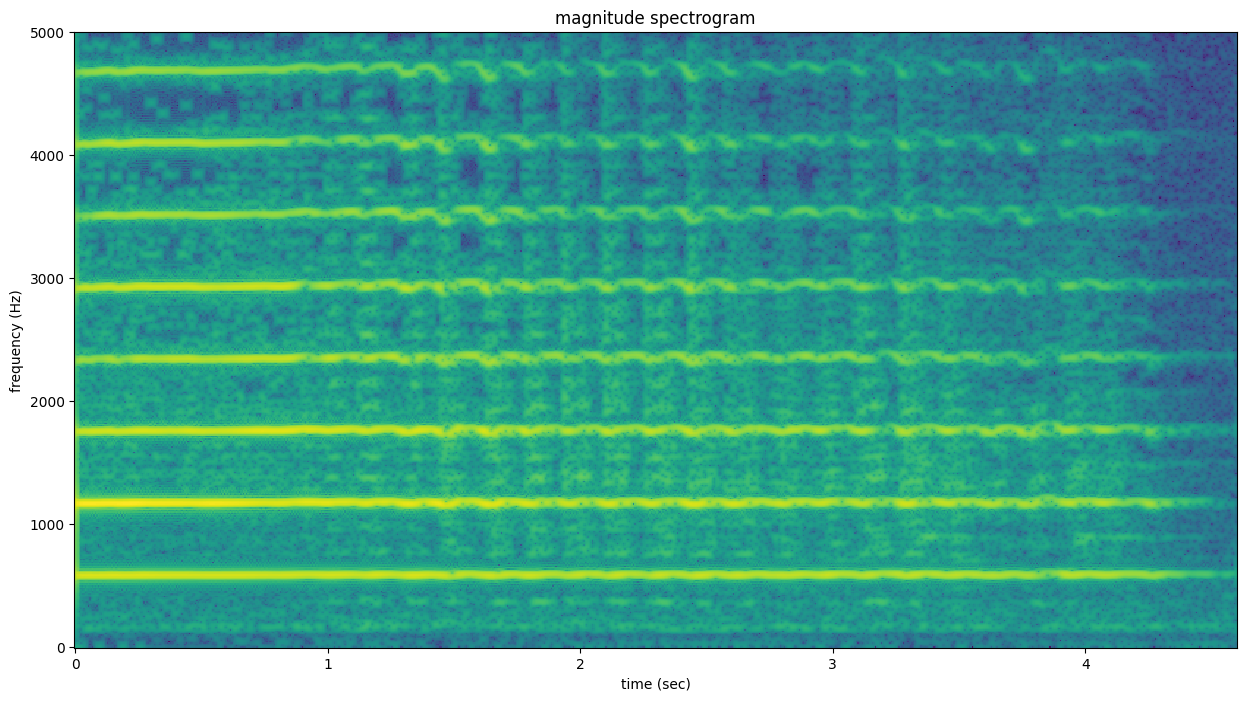

In [106]:
# E7 - 2.3: 
# Set STFT analysis parameters and visualize spectrogram of chosen sound. Explain relevant sound 
# characteristics for HPS model.

### basic visualization and listening of sound
'''
input_file = 'XXX'
window = 'XXX'
M = XX
N = XX
H = XX
'''

input_file = '../sounds/trumpet_susvib_D5_mono.wav'
window = 'hann'
M = 2048
N = 4096
H = 256

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

Numeric analysis

In [107]:
import numpy as np

duration_sec = x.size / float(fs)
rms = np.sqrt(np.mean(x**2))
peak = np.max(np.abs(x))
zcr = np.sum(x[:-1] * x[1:] < 0) / duration_sec

N_fft = 2 ** int(np.ceil(np.log2(x.size)))
X_full = np.fft.rfft(x, n=N_fft)
mag_full = np.abs(X_full)
freqs_full = np.fft.rfftfreq(N_fft, d=1.0 / fs)
spectral_centroid = np.sum(freqs_full * mag_full) / np.sum(mag_full)

mask = (freqs_full >= 200.0) & (freqs_full <= 2000.0)
dominant_idx = np.argmax(mag_full[mask])
dominant_freq = freqs_full[mask][dominant_idx]

min_f0_est = dominant_freq * 0.95
max_f0_est = dominant_freq * 1.05
max_harmonics_5k = int(5000.0 / dominant_freq)

mid_frame = numFrames // 2
frame_mag = mX[mid_frame, :]
frame_max = np.max(frame_mag)
threshold = frame_max - 40.0
valid_bins = np.where(frame_mag >= threshold)[0]
harmonic_count_est = valid_bins.size
freq_resolution = fs / float(N)

print("Trumpet analysis Part 2.2:")
print(f"Duration: {duration_sec:.3f} s")
print(f"RMS level: {rms:.6f}")
print(f"Peak amplitude: {peak:.6f}")
print(f"Zero crossing rate: {zcr:.2f} crossings")
print(f"Global spectral centroid : {spectral_centroid:.2f} hz")
print(f"Approximate fundamental frequency: {dominant_freq:.2f} hz")
print(f"Estimated pitch range around f0: [{min_f0_est:.2f}, {max_f0_est:.2f}] hz")
print(f"Theoretical max harmonics up to 5 kHz: {max_harmonics_5k}")
print(f"Estimated strong spectral components in a mid frame (above -40 db): {harmonic_count_est}")
print(f"Frequency resolution: {freq_resolution:.2f} hz per bin")

Trumpet analysis Part 2.2:
Duration: 4.600 s
RMS level: 0.030801
Peak amplitude: 0.205444
Zero crossing rate: 2037.17 crossings
Global spectral centroid : 2906.70 hz
Approximate fundamental frequency: 1171.20 hz
Estimated pitch range around f0: [1112.64, 1229.76] hz
Theoretical max harmonics up to 5 kHz: 4
Estimated strong spectral components in a mid frame (above -40 db): 137
Frequency resolution: 10.77 hz per bin


In [108]:
approx_f0 = dominant_freq / 2.0
min_f0_est_refined = approx_f0 * 0.95
max_f0_est_refined = approx_f0 * 1.05
max_harmonics_5k_refined = int(5000.0 / approx_f0)

print("trumpet fundamental estimation:")
print(f"fundamental frequency: {approx_f0:.2f} Hz")
print(f"estimated pitch range: [{min_f0_est_refined:.2f}, {max_f0_est_refined:.2f}] Hz")
print(f"theoretical max harmonics up to 5 kHz: {max_harmonics_5k_refined}")

trumpet fundamental estimation:
fundamental frequency: 585.60 Hz
estimated pitch range: [556.32, 614.88] Hz
theoretical max harmonics up to 5 kHz: 8


**2.3**

In [109]:
import numpy as np
from scipy.signal import find_peaks

frame_f0_estimates = []
harmonics_per_frame = []
noise_floor_estimates = []
frame_energy = []

freq_axis = fs * np.arange(N//2+1) / N

for i in range(numFrames):
    frame_mag = mX[i, :N//2+1]

    frame_energy.append(np.sum(frame_mag))

    peaks, _ = find_peaks(frame_mag, distance=5)
    peaks = peaks[frame_mag[peaks] > (np.max(frame_mag) - 40)]
    peak_freqs = freq_axis[peaks]
    if len(peak_freqs) == 0:
        frame_f0_estimates.append(0)
        harmonics_per_frame.append(0)
        noise_floor_estimates.append(np.mean(frame_mag))
        continue

    df = np.diff(peak_freqs)
    df = df[(df > 100) & (df < 2000)]
    if len(df) > 0:
        f0_est = np.median(df)
    else:
        f0_est = 0

    frame_f0_estimates.append(f0_est)
    harmonics_per_frame.append(len(peak_freqs[peak_freqs < 5000]))
    noise_floor_estimates.append(np.mean(frame_mag))

frame_f0_estimates = np.array(frame_f0_estimates)
harmonics_per_frame = np.array(harmonics_per_frame)
noise_floor_estimates = np.array(noise_floor_estimates)
frame_energy = np.array(frame_energy)

stable_f0 = frame_f0_estimates[(frame_f0_estimates > 300) & (frame_f0_estimates < 900)]
mean_f0 = np.mean(stable_f0)
min_f0 = np.min(stable_f0)
max_f0 = np.max(stable_f0)

print("==== HPS-Relevant Numerical Analysis ====")
print(f"Frames analyzed: {numFrames}")
print(f"Estimated per-frame f0 mean: {mean_f0:.2f} Hz")
print(f"Estimated per-frame f0 min: {min_f0:.2f} Hz")
print(f"Estimated per-frame f0 max: {max_f0:.2f} Hz")
print(f"Mean harmonics below 5 kHz: {np.mean(harmonics_per_frame):.2f}")
print(f"Max harmonics in any frame: {np.max(harmonics_per_frame)}")
print(f"Min harmonics in any frame: {np.min(harmonics_per_frame)}")
print(f"Mean noise floor magnitude: {np.mean(noise_floor_estimates):.4f}")
print(f"Frame energy variation (std/mean): {np.std(frame_energy) / np.mean(frame_energy):.4f}")

==== HPS-Relevant Numerical Analysis ====
Frames analyzed: 793
Estimated per-frame f0 mean: 530.17 Hz
Estimated per-frame f0 min: 301.46 Hz
Estimated per-frame f0 max: 592.16 Hz
Mean harmonics below 5 kHz: 16.44
Max harmonics in any frame: 40
Min harmonics in any frame: 6
Mean noise floor magnitude: -116.0708
Frame energy variation (std/mean): -0.0457


**======================================================= ANSWER 2.3. =======================================================**
instructions:
_Part 2.3: Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter._

Chosen parameters:
* Window type: blackman because it produces well defined harmonic peaks
* Window size: 2048 samples provide sufficient frequency resolution 
* FFT SIze: 4096 gives good interpolation for harmonic peak estimation
* Min f0: 520 hz to remain slightly below the vibrato range
* Max f0: 650 hz to cover the vibrato fluctuation
* F0et: 5 to make the algorithm selective
* Harmonics: 20 because the analysis showed 16 harmonics below 5khz 
* Stochastic decimation factor: 0.2 to achieve a smooth and compact stochastic envelope

**Question E7 - 2.4:**

### Describe the characteristics relevant to perform the harmonic plus stochastic analysis

____

The trumpet sound is a very stable monophonic and harmonic sound. It has a clear fundamental frequency (around 585hz) and small vibrato fluctuations (as it can be seen in the f0 range of 530 to 592hz). The spectogram shows clear harmonic series, with an average of 16 harmonics below 5khz and around 40 peaks, which suggests harmonic richness. The characteristics of the sound make it ideal for harmonic plus stochastic model and allow us to reconstruct it accurately with compact harmonic parameters.


In [110]:
# E7 - 2.5: 
# Perform Harmonic plus Stochastic analysis and synthesis of chosen sound.


### fill the parameters
'''
input_file = 'XXX'
window ='XXX'
M = XXX
N = XXX
t = XXX
minSineDur = XXX
nH = XXX 
minf0 = XXX
maxf0 = XXX
f0et = XXX
harmDevSlope = XXX
stocf = XXX
'''

input_file = '../sounds/trumpet_susvib_D5_mono.wav'
window = 'blackman'
M = 2048
N = 4096
t = -90
minSineDur = 0.05
nH = 25
minf0 = 520
maxf0 = 650
f0et = 5
harmDevSlope = 0.01
stocf = 0.3

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Question E7 - 2.5**

### Explain the choices of HPS analysis parameters
___

* Window type: blackman as it strongly reduces spectral leakage and provides clean harmonic peaks
* Window size: 20248 samples gives enough frequency resolution to separate harmonics around 585hz, and we can still hear the vibrato
* FFT size: 4096 next power of two thats above the window size to get sufficient spectral interpolation so we can have accurate peak and f0 estimation
* Minimum f0: 520hz so it stays below the f0 range 
* Maximum f0: 650hz to cover the vibrato 
* f0et: 5 to make the algorithm selective enough to keep the frames with stable harmonics
* nh: 25 harmonics because the analysis suggests average of 12 active harmonics and I tried with double the size and it sounded clearer.
* Stocf: 0.3 to get a detailed but compact stochastic envelope

**Codigo complementario para analizar numericamente**

===== HPS Numerical Analysis Part 2.5 =====
Original RMS: 0.030809
Resynthesis RMS: 0.030705
Error RMS: 0.004807
SNR (x vs y): 16.14 db
Original peak: 0.205444
Resynthesis peak: 0.202910
Harmonic component RMS (yh): 0.030535
Stochastic component RMS (yst): 0.003437
Frames: 1585
Max harmonics per frame: 25
Min harmonics per frame: 0
Mean harmonics per frame: 11.46
Stochastic envelope shape: (1585, 38)


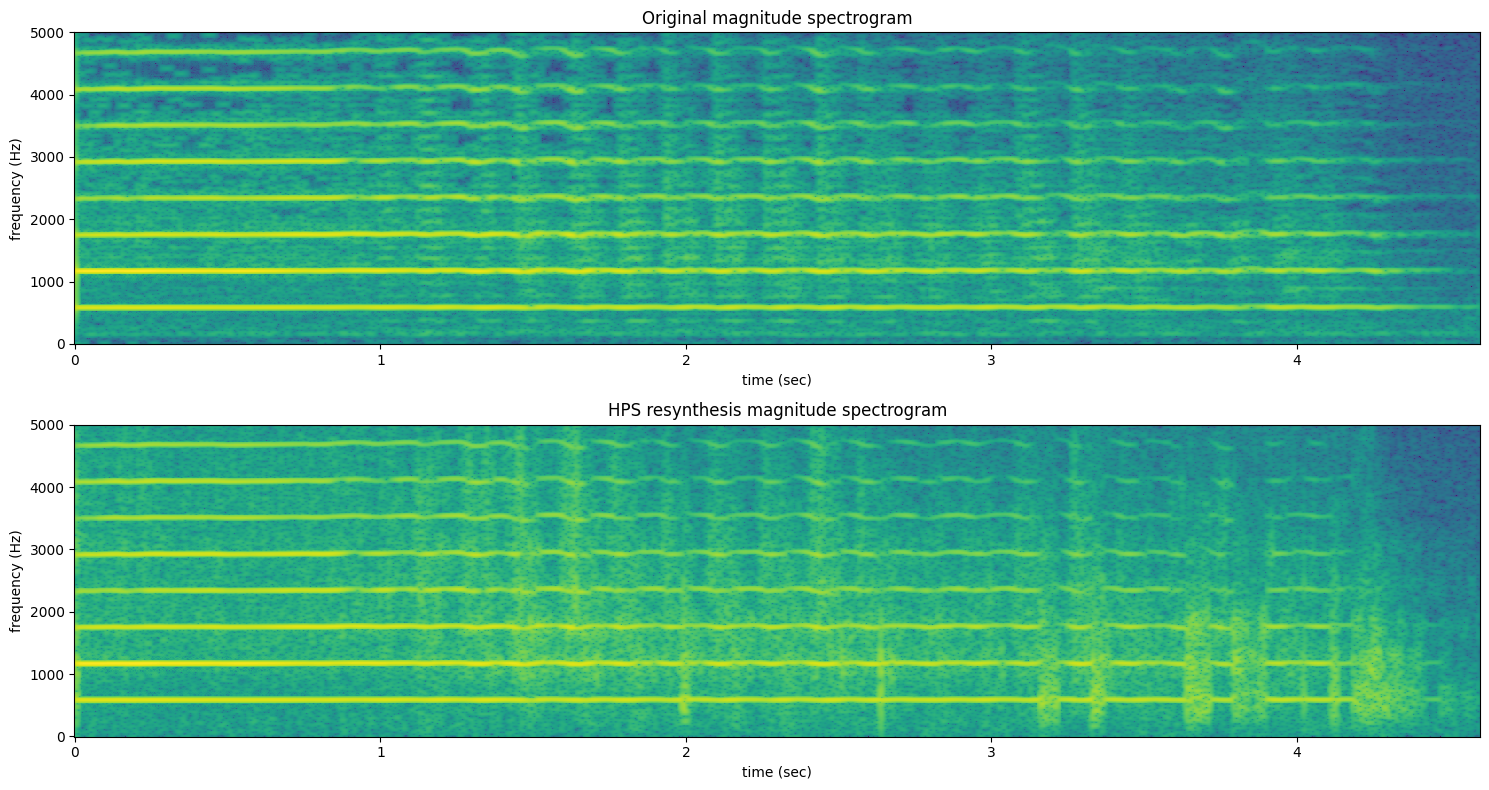

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from smstools.models import stft as STFT

L = min(len(x), len(y))
x_al = x[:L]
y_al = y[:L]
e = x_al - y_al

rms_x = np.sqrt(np.mean(x_al**2))
rms_y = np.sqrt(np.mean(y_al**2))
rms_e = np.sqrt(np.mean(e**2))
snr = 20 * np.log10(rms_x / rms_e)

peak_x = np.max(np.abs(x_al))
peak_y = np.max(np.abs(y_al))

Lh = min(len(x), len(yh))
yh_al = yh[:Lh]
yst_al = yst[:Lh]

rms_yh = np.sqrt(np.mean(yh_al**2))
rms_yst = np.sqrt(np.mean(yst_al**2))

active_harmonics_per_frame = np.sum(hfreq > 0, axis=1)
mean_harmonics = np.mean(active_harmonics_per_frame)
max_harmonics = np.max(active_harmonics_per_frame)
min_harmonics = np.min(active_harmonics_per_frame)

w_an = get_window(window, M, fftbins=True)
mX_orig, pX_orig = STFT.stftAnal(x_al, w_an, N, H)
mX_y, pX_y = STFT.stftAnal(y_al, w_an, N, H)

maxplotfreq = 5000.0
numFrames_plot = int(mX_orig[:, 0].size)
frmTime_plot = H * np.arange(numFrames_plot) / float(fs)
binFreq_plot = fs * np.arange(int(N * maxplotfreq / fs) + 1) / N

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.pcolormesh(frmTime_plot, binFreq_plot, np.transpose(mX_orig[:, :int(N * maxplotfreq / fs) + 1]))
plt.xlabel("time (sec)")
plt.ylabel("frequency (Hz)")
plt.title("Original magnitude spectrogram")
plt.subplot(2, 1, 2)
plt.pcolormesh(frmTime_plot, binFreq_plot, np.transpose(mX_y[:, :int(N * maxplotfreq / fs) + 1]))
plt.xlabel("time (sec)")
plt.ylabel("frequency (Hz)")
plt.title("HPS resynthesis magnitude spectrogram")
plt.tight_layout()

print("===== HPS Numerical Analysis Part 2.5 =====")
print(f"Original RMS: {rms_x:.6f}")
print(f"Resynthesis RMS: {rms_y:.6f}")
print(f"Error RMS: {rms_e:.6f}")
print(f"SNR (x vs y): {snr:.2f} db")
print(f"Original peak: {peak_x:.6f}")
print(f"Resynthesis peak: {peak_y:.6f}")
print(f"Harmonic component RMS (yh): {rms_yh:.6f}")
print(f"Stochastic component RMS (yst): {rms_yst:.6f}")
print(f"Frames: {hfreq.shape[0]}")
print(f"Max harmonics per frame: {max_harmonics}")
print(f"Min harmonics per frame: {min_harmonics}")
print(f"Mean harmonics per frame: {mean_harmonics:.2f}")
print(f"Stochastic envelope shape: {stocEnv.shape}")